#### NOTES
Runoff all the code. Some cells uses the outputs from other cell

In [1]:
#Array packages
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import scienceplots

plt.style.use(['science','no-latex','bright'])

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy

import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\1_Streamflow")
print(os.getcwd())

c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\1_Streamflow


In [2]:
gauge_info=pd.read_csv('3_Data/Data_p/2_Station/gauge_info_p.csv',index_col=0)
gauge_info1=gauge_info.iloc[:,1:5]
gauge_sf=xr.open_dataset(f'3_Data/Data_p/2_Station/Gauge_streamflow.nc')
gauge_ind=xr.open_mfdataset(f'3_Data/Data_p/2_Station/Gauge_indices.nc')
ILDAS_sf=xr.open_mfdataset(f'3_Data/Data_p/1_ILDAS/ILDAS_station_streamflow.nc')
ILDAS_ind=xr.open_mfdataset(f'3_Data/Data_p/1_ILDAS/ILDAS_station_indices.nc')

data1=sorted(glob.glob(f'3_Data/Data_r/1_ILDAS/*.nc*'))
d_IL = xr.open_mfdataset(data1, combine='by_coords',engine='netcdf4', parallel=True,chunks={'time': 'auto'})
d_IL=d_IL.resample(time='M').mean().compute()

c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\xarray\core\groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


## 2.1 Distance between ILDAS grid vs Gauge Station location 

In [3]:
gauge_info1=gauge_info.iloc[:,1:5]
station=gauge_info['Station'].to_numpy()

lat=d_IL['lat'].values
lon=d_IL['lon'].values

#I_lat=d_IL['lat'].values
gauge_info1
gauge_info1.loc[0,'Longitude']
gauge_info1.loc[0,'Latitude']

for i in range(len(gauge_info1)):
    dif_lat=np.abs(lat-gauge_info1.loc[i,'Latitude'])
    gauge_info1.loc[i,'lat']=lat[np.argmin(dif_lat)]

    dif_lon=np.abs(lon-gauge_info1.loc[i,'Longitude'])
    gauge_info1.loc[i,'lon']=lon[np.argmin(dif_lon)]

gauge_info1['diff']=np.sqrt((gauge_info1['Latitude']-gauge_info1['lat'])**2+(gauge_info1['Longitude']-gauge_info1['lon'])**2)

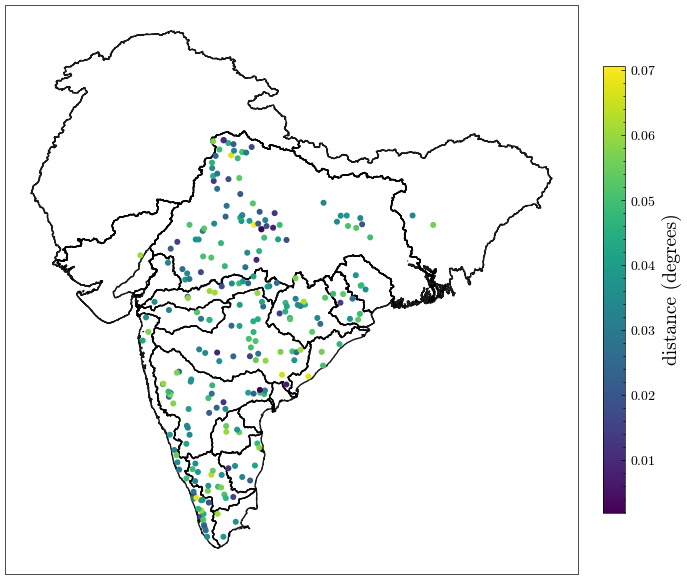

In [4]:
fig,ax=plt.subplots(figsize=(8,8),subplot_kw={'projection':ccrs.PlateCarree()})
south_asia=gpd.read_file(r'3_Data\Data_p\3_Shapefiles\south_asia_p.shp')

south_asia.plot(ax=ax,color = 'none',edgecolor = 'Black',linewidth=1,alpha=0.9)
sc=ax.scatter(gauge_info1['Longitude'],gauge_info1['Latitude'],c=gauge_info1['diff'],s=11)
#sc1=ax.scatter(gauge_info1['lon'],gauge_info1['lat'],c=gauge_info1['diff'],s=18)
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.036, pad=0.04)  #rmse - 0 -1000
cbar.set_label('distance (degrees)', fontsize=14)

plt.savefig(f'2_Streamflow_Analysis/1_Checks/outputs/2.1 distance.jpeg')

## 2.2 Correlation Streamflow 

In [5]:

station=gauge_sf['station'].values
df=pd.DataFrame(index=gauge_sf['time'].values,columns=['Gauge','ILDAS'])
dt=pd.date_range('1975','2021',freq='d')
#pd.DataFrame(gauge_sf)
#gauge_sf=gauge_sf.resample(time='M')
#gauge_ind=gauge_ind.resample(time='M')

for s,stn in enumerate(station):
    df['Gauge']=gauge_sf['streamflow'].sel(station=stn).values
    df['ILDAS']=ILDAS_sf['streamflow'].sel(station=stn).values

    df1=df[df['Gauge'].notna()]
    gauge_info1.loc[s,['Correlation_sf']]=df1.corr().to_numpy()[0,1]
    gauge_info1.loc[s,['Rmse_sf']]=np.sqrt(((df1['Gauge'] - df1['ILDAS']) ** 2).mean())



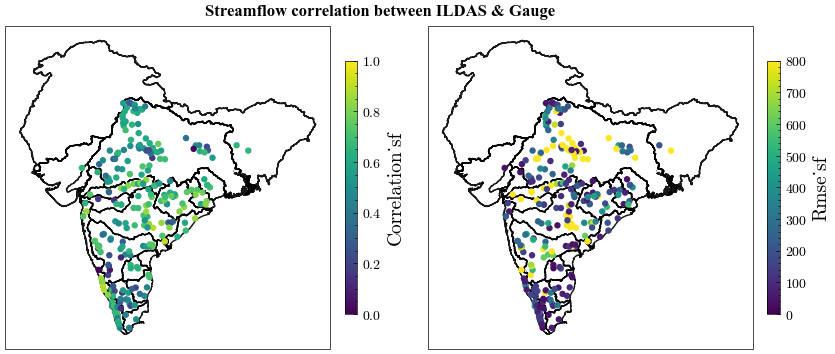

In [6]:
PI=['Correlation_sf','Rmse_sf']    #performance index
vlim=[[0,1],[0,800]]
fig,ax=plt.subplots(1,2,figsize=(10,6),subplot_kw={'projection':ccrs.PlateCarree()})
ax1=ax.flatten()
south_asia=gpd.read_file(r'3_Data\Data_p\3_Shapefiles\south_asia_p.shp')

for i in range(2):
    south_asia.plot(ax=ax1[i],color = 'none',edgecolor = 'Black',linewidth=1,alpha=0.9)
    sc=ax1[i].scatter(gauge_info1['Longitude'],gauge_info1['Latitude'],c=gauge_info1[PI[i]],s=13,vmin=vlim[i][0],vmax=vlim[i][1])  #corr or rmse
    #sc1=ax.scatter(gauge_info1['lon'],gauge_info1['lat'],c=gauge_info1['diff'],s=18)
    cbar = plt.colorbar(sc, ax=ax1[i], orientation='vertical', fraction=0.036, pad=0.04,label = PI[i])  #rmse - 0 -1000
    cbar.set_label(f'{PI[i]}', fontsize=14)

    fig.suptitle(f'Streamflow correlation between ILDAS & Gauge', fontsize=12, y=0.8, fontweight='bold', fontname='Times New Roman')
    plt.savefig(f'2_Streamflow_Analysis/1_Checks/outputs/2.2 streamflow_PI.jpeg')

## 2.3 Correlation - Streamflow Index

In [7]:
n=1
indx=['drt_flow','fld_flow']

station=gauge_sf['station'].values
df=pd.DataFrame(index=gauge_ind['time'].values,columns=['Gauge','ILDAS'])
dt=pd.date_range('1975','2021',freq='Y')
#pd.DataFrame(gauge_sf)
#gauge_sf=gauge_sf.resample(time='M')
#gauge_ind=gauge_ind.resample(time='M')

for s,stn in enumerate(station):
    df['Gauge']=gauge_ind[indx[n]].sel(station=stn,season='All').values
    df['ILDAS']=ILDAS_ind[indx[n]].sel(station=stn,season='All').values

    df1=df[df['Gauge'].notna()]
    gauge_info1.loc[s,[f'Correlation_{indx[n][0:3]}']]=df1.corr().to_numpy()[0,1]
    gauge_info1.loc[s,[f'Rmse_{indx[n][0:3]}']]=np.sqrt(((df1['Gauge'] - df1['ILDAS']) ** 2).mean())



C:\Users\sstar\AppData\Local\Temp\ipykernel_15856\1171871181.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dt=pd.date_range('1975','2021',freq='Y')


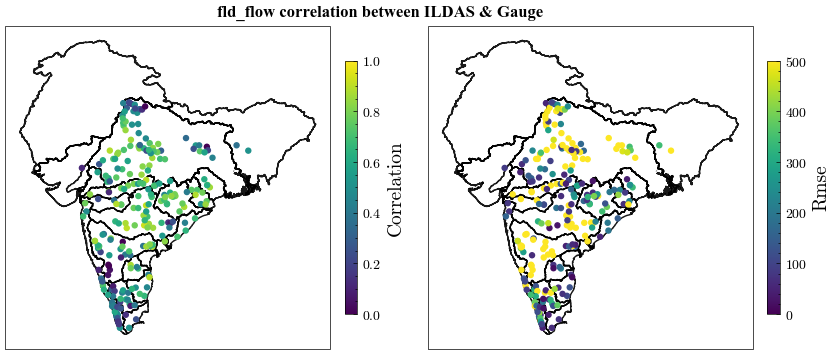

In [8]:
PI=['Correlation','Rmse']    #performance index
vlim=[[0,1],[0,500]]
fig,ax=plt.subplots(1,2,figsize=(10,6),subplot_kw={'projection':ccrs.PlateCarree()})
ax1=ax.flatten()
south_asia=gpd.read_file(r'3_Data\Data_p\3_Shapefiles\south_asia_p.shp')

for i in range(2):
    south_asia.plot(ax=ax1[i],color = 'none',edgecolor = 'Black',linewidth=1,alpha=0.9)
    sc=ax1[i].scatter(gauge_info1['Longitude'],gauge_info1['Latitude'],c=gauge_info1[f'{PI[i]}_{indx[n][0:3]}'],s=13,vmin=vlim[i][0],vmax=vlim[i][1])  #corr or rmse
    #sc1=ax.scatter(gauge_info1['lon'],gauge_info1['lat'],c=gauge_info1['diff'],s=18)
    cbar = plt.colorbar(sc, ax=ax1[i], orientation='vertical', fraction=0.036, pad=0.04,label = PI[i])  #rmse - 0 -1000
    cbar.set_label(f'{PI[i]}', fontsize=14)

    fig.suptitle(f'{indx[n]} correlation between ILDAS & Gauge', fontsize=12, y=0.8, fontweight='bold', fontname='Times New Roman')
    plt.savefig(f'2_Streamflow_Analysis/1_Checks/outputs/2.3 {indx[n]}_PI.jpeg')

## 3 Timeseries

### 3.1 Streamflow

In [45]:
station1=gauge_info1[gauge_info1['Correlation_sf']>0.8][0:40]['Station'].to_list()

df=pd.DataFrame(index=gauge_sf['time'].values,columns=['Gauge','ILDAS'])


for stn in tqdm(station1):

    df['Gauge']=gauge_sf['streamflow'].sel(station=stn).values
    df['ILDAS']=ILDAS_sf['streamflow'].sel(station=stn).values

    df1=df[df['Gauge'].notna()]
    df2=df1.resample('ME').mean()       # Monthly
    yr=df2.index.values

    fig,ax=plt.subplots(figsize=(12,5.5),dpi=500)
    import scienceplots
    plt.style.use(['science','no-latex','bright'])


    ax.plot(yr, df2['Gauge'], color='green', label='Gauge', alpha=1, linewidth=1)
    ax.plot(yr, df2['ILDAS'], color='red', label='ILDAS', alpha=1, linewidth=0.81,linestyle='--')

    ax.xaxis.set_tick_params(which='both', bottom=True, top=False,labelsize=13)
    ax.yaxis.set_tick_params(which='both', left=True, right=False,labelsize=13)

    ax.set_xlim([pd.to_datetime('1975'), pd.to_datetime('2020')])
    ax.set_ylim([0, 4000])
    [x.set_linewidth(1.25) for x in ax.spines.values()]

    ax.set_title(f'{stn}(streamflow Monthly)', fontsize=17)

    lgnd=ax.legend(loc='center', ncol=1,fontsize=13, bbox_to_anchor=(0.8, 0.9),frameon=True, borderpad=0.2, edgecolor='black')
    frame = lgnd.get_frame()
    frame.set_linewidth(0.5)

    ax2 = fig.add_axes([0.2, 0.8, 0.25, 0.25], projection=ccrs.PlateCarree())
    south_asia.plot(ax=ax2,color = 'none',edgecolor = 'Black',linewidth=0.05,alpha=0.9)
    ax2.scatter(gauge_info1[gauge_info1['Station']==stn]['Longitude'],gauge_info1[gauge_info1['Station']==stn]['Latitude'],s=10)

    plt.savefig(f'2_Streamflow_Analysis/1_Checks/outputs/timeseries/{stn}.jpeg')
    plt.close(fig)




100%|██████████| 23/23 [01:01<00:00,  2.69s/it]


In [46]:

#Create GIF
import imageio
images = [imageio.imread(f'2_Streamflow_Analysis/1_Checks/outputs/timeseries/{stn}.jpeg') for stn in station1]
imageio.mimsave(f'2_Streamflow_Analysis/1_Checks/outputs/3. streamflow_M_gif.gif', images,duration=1700,loop=0,dpi=300)  
df=pd.DataFrame(index=ILDAS_ind['time'].values,columns=['Gauge','ILDAS'])


C:\Users\sstar\AppData\Local\Temp\ipykernel_15856\593537828.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f'2_Streamflow_Analysis/1_Checks/outputs/timeseries/{stn}.jpeg') for stn in station1]


### 3.2 Flood flow

In [47]:
station1=gauge_info1[gauge_info1['Correlation_fld']>0.8][0:40]['Station'].to_list()

df=pd.DataFrame(index=ILDAS_ind['time'].values,columns=['Gauge','ILDAS'])


for stn in tqdm(station1):

    df=pd.DataFrame(index=ILDAS_ind['time'].values,columns=['Gauge','ILDAS'])
    df['Gauge']=gauge_ind['drt_flow'].sel(station=stn,season='All').values
    df['ILDAS']=ILDAS_ind['drt_flow'].sel(station=stn,season='All').values

    df1=df[df['Gauge'].notna()]
    yr=df1.index.values

    fig,ax=plt.subplots(figsize=(12,5.5))
    import scienceplots
    plt.style.use(['science','no-latex','bright'])


    ax.plot(yr, df1['Gauge'], color='green', label='Gauge', alpha=1, linewidth=1)
    ax.plot(yr, df1['ILDAS'], color='red', label='ILDAS', alpha=1, linewidth=0.81,linestyle='--')

    ax.xaxis.set_tick_params(which='both', bottom=True, top=False,labelsize=13)
    ax.yaxis.set_tick_params(which='both', left=True, right=False,labelsize=13)

    ax.set_xlim([pd.to_datetime('1975'), pd.to_datetime('2020')])
    ax.set_ylim([0, 50])

    ax.set_title(f'{stn}', fontsize=15)

    lgnd=ax.legend(loc='center', ncol=1,fontsize=13, bbox_to_anchor=(0.8, 0.9),frameon=True, borderpad=0.2, edgecolor='black')
    frame = lgnd.get_frame()
    frame.set_linewidth(0.5)

    ax2 = fig.add_axes([0.2, 0.8, 0.25, 0.25], projection=ccrs.PlateCarree())
    south_asia.plot(ax=ax2,color = 'none',edgecolor = 'Black',linewidth=0.05,alpha=0.9)
    ax2.scatter(gauge_info1[gauge_info1['Station']==stn]['Longitude'],gauge_info1[gauge_info1['Station']==stn]['Latitude'],s=10)

    plt.savefig(f'2_Streamflow_Analysis/1_Checks/outputs/timeseries/drt_{stn}.jpeg')
    plt.close(fig)




100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


In [48]:
#Create GIF
import imageio
images = [imageio.imread(f'2_Streamflow_Analysis/1_Checks/outputs/timeseries/{stn}.jpeg') for stn in station1]
imageio.mimsave(f'2_Streamflow_Analysis/1_Checks/outputs/3. drtflow_gif.gif', images,duration=500,loop=0,dpi=300)  


C:\Users\sstar\AppData\Local\Temp\ipykernel_15856\3967013404.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f'2_Streamflow_Analysis/1_Checks/outputs/timeseries/{stn}.jpeg') for stn in station1]


ValueError: all input arrays must have the same shape